# **BCG X Capstone Project** 
<img src="https://web-assets.bcg.com/1a/1f/6b52570e4ba49920815bdda88e36/bcgx-meet-banner.jpg" alt="drawing" style="width:800px; height:300px"/>

### **Pre-processing Steps and Exploratory Data Analysis Notebook**

**Group members**

Morten Aas-Lyngby, Paolo Brambillasca,  Ignacio Alonso Lopez-Linares, Emilio Jair Rodriguez Capitan, Alberto Dona



**Notebook description**

This notebook provides the first steps in our Analysis. It starts by formatting and cleaning the dataset while optimizing memory. Then, we explore the data visually to unfold trends. We will also create a client table for analysis and building the model. Last but not least, we explore Data distributions and Quantiles.

**Problem definition**

The Team has been tasked with building a Churn Model to increase CLTV as well as to help ClienCo. in their product cross-selling strategy and demand forecasting problem.

# Table of Contents

1. [Import the Necessary Libraries](#1-import-the-necessary-libraries)
2. [Dataset Loading](#2-dataset-loading)
3. [Data Formatting & Cleaning](#3-data-formatting--cleaning)
4. [Feature Engineering](#4-feature-engineering)
   - [4.1 Interaction Features](#41-interaction-features)
   - [4.2 Date Based Features](#42-date-based-features)
   - [4.3 Aggregating Features](#43-aggregating-features)
   - [4.4 Lag Features](#44-lag-features)
   - [4.5 Memory Optimization with Numpy and Saving the file to Parquet](#45-memory-optimization-with-numpy-and-saving-the-file-to-parquet)
5. [Exploration Data Analysis (EDA): Trends and Behaviours](#5-exploration-data-analysis-eda-trends-and-behaviours)
   - [5.1 Sales per Channel](#51-sales-per-channel)
   - [5.2 Seasonal Time Lines Decomposition](#52-seasonal-time-lines-decomposition)
   - [5.3 Sales per Day of Week](#53-sales-per-day-of-week)
   - [5.4 Day of Week Metrics - Interactive Plot](#54-day-of-week-metrics---interactive-plot)
   - [5.5 Curve of Client Sales Distribution](#55-curve-of-client-sales-distribution)
   - [5.6 Monthly Refunds over time](#56-monthly-refunds-over-time)
   - [5.7 Sales and Refunds over time](#57-sales-and-refunds-over-time)
   - [5.8 Transactions Over time, CLTV Curve](#58-transactions-over-time-cltv-curve)
   - [5.9 Curve of Product Sales Distribution](#59-curve-of-product-sales-distribution)
   - [5.10 Top 20 Branches By Number of Sales](#510-top-20-branches-by-number-of-sales)
6. [Creating a Final Client Analysis Table](#6-creating-a-final-client-analysis-table)
   - [6.1 Creating additional features within the table](#61-creating-additional-features-within-the-table)
   - [6.2 Checking for infinite values](#62-checking-for-infinite-values)
   - [6.3 Memory Optimization with Numpy and Saving the file to Parquet](#63-memory-optimization-with-numpy-and-saving-the-file-to-parquet)
7. [Quantiles and Client Distributions](#7-quantiles-and-client-distributions)
   - [7.1 Initial Distribution](#71-initial-distribution)
   - [7.2 Applying a log transformation for normality](#72-applying-a-log-transformation-for-normality)
   - [7.3 Quantiles Analysis](#73-quantiles-analysis)


### **1. Import the Necessary Libraries**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats import uniform, randint
import joblib

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.figure_factory as ff
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import probplot
from pandas.api.types import CategoricalDtype

### **2. Dataset loading**

In [2]:
# We import the dataset using pandas
t=pd.read_csv('data/transactions_dataset.csv',delimiter=';')

### **3. Data Formatting & Cleaning**

In [3]:
# Checking data types and structure
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date_order     object 
 1   date_invoice   object 
 2   product_id     int64  
 3   client_id      int64  
 4   sales_net      float64
 5   quantity       int64  
 6   order_channel  object 
 7   branch_id      int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.8+ GB


In [4]:
t.describe()

,product_id,client_id,sales_net,quantity,branch_id
count,6.331932e+07,6.331932e+07,6.331932e+07,6.331932e+07,6.331932e+07
mean,1.632321e+06,1.139833e+06,1.479416e+02,9.215658e+01,5.466714e+03
std,9.184524e+05,6.552536e+05,8.646548e+02,8.674801e+02,3.175258e+03
min,1.500000e+01,6.000000e+00,-1.738817e+06,3.000000e+00,2.000000e+01
25%,8.517370e+05,5.658470e+05,1.414653e+01,3.000000e+00,2.907000e+03
50%,1.621731e+06,1.152241e+06,4.424280e+01,5.000000e+00,5.226000e+03
75%,2.434262e+06,1.706977e+06,1.314680e+02,2.100000e+01,8.361000e+03
max,3.238833e+06,2.274517e+06,1.740456e+06,1.980010e+05,1.105700e+04


We can immediately see that 'date_order' and 'date_invoice' are set as object and we might want to format into pandas date before analysis

In [5]:
# We check a few rows of the data to gain a better understanding and to establish how to format the dates

t.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


#### 3.1 Date Formatting

Let's format dates

In [6]:
# We proceed with formatting the dates
t['date_order'] = pd.to_datetime(t['date_order'], format='%Y-%m-%d')
t['date_invoice'] = pd.to_datetime(t['date_invoice'], format='%Y-%m-%d')

In [7]:
# We check if formatting worked properly

t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date_order     datetime64[ns]
 1   date_invoice   datetime64[ns]
 2   product_id     int64         
 3   client_id      int64         
 4   sales_net      float64       
 5   quantity       int64         
 6   order_channel  object        
 7   branch_id      int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 3.8+ GB


#### 3.2 Null values and Duplicates cleaning

##### 3.2.1 Null values & Inputing

In [8]:
# We find there is only 1 missing value

t.isnull().sum()


date_order       0
date_invoice     1
product_id       0
client_id        0
sales_net        0
quantity         0
order_channel    0
branch_id        0
dtype: int64

We have one null value for the invoice date. Let's find the mean value for invoice_delay for this customer and impute this.

In [9]:
t['invoice_delay'] = t['date_invoice'] - t['date_order']
t['invoice_delay'] = t['invoice_delay'].dt.days

In [10]:
null_date_rows = t[(t['client_id'] == 2063897) & (t['date_invoice'].isnull())]
null_date_rows

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,invoice_delay
63288649,2019-07-18,NaT,2005960,2063897,56.6076,3,at the store,7993,NaN


In [11]:
t[t['client_id']==2063897]['invoice_delay'].value_counts()

invoice_delay
0.0      1267
1.0        59
5.0        49
12.0       48
6.0        38
16.0       37
44.0       29
3.0        27
18.0       23
4.0        20
56.0       20
27.0       17
14.0       16
8.0        15
10.0       13
43.0       12
7.0        12
13.0       11
33.0       10
284.0       9
15.0        9
9.0         8
17.0        8
26.0        7
53.0        7
47.0        6
63.0        6
2.0         6
83.0        6
11.0        5
28.0        4
55.0        4
20.0        3
29.0        3
71.0        3
30.0        3
21.0        2
64.0        2
179.0       2
22.0        1
36.0        1
104.0       1
62.0        1
23.0        1
175.0       1
19.0        1
48.0        1
90.0        1
309.0       1
Name: count, dtype: int64

In [12]:
null_invoice_mean = t[t['client_id']==2063897]['invoice_delay'].mean() #or mode?
null_invoice_mean


np.float64(7.381263616557734)

In [13]:
null_invoice_mean_timedelta = pd.Timedelta(days=null_invoice_mean)


t.loc[t['date_invoice'].isnull(), 'date_invoice'] = t['date_order'] + null_invoice_mean_timedelta
t.loc[t['invoice_delay'].isnull(), 'invoice_delay'] = null_invoice_mean

In [14]:
t.isnull().sum()

date_order       0
date_invoice     0
product_id       0
client_id        0
sales_net        0
quantity         0
order_channel    0
branch_id        0
invoice_delay    0
dtype: int64

Boom! Problem solved!

In [15]:
# Removing the NaN values for double checking

t.dropna(inplace=True)
t.reset_index(drop=True, inplace=True)

##### 3.2.2 Duplicates cleaning

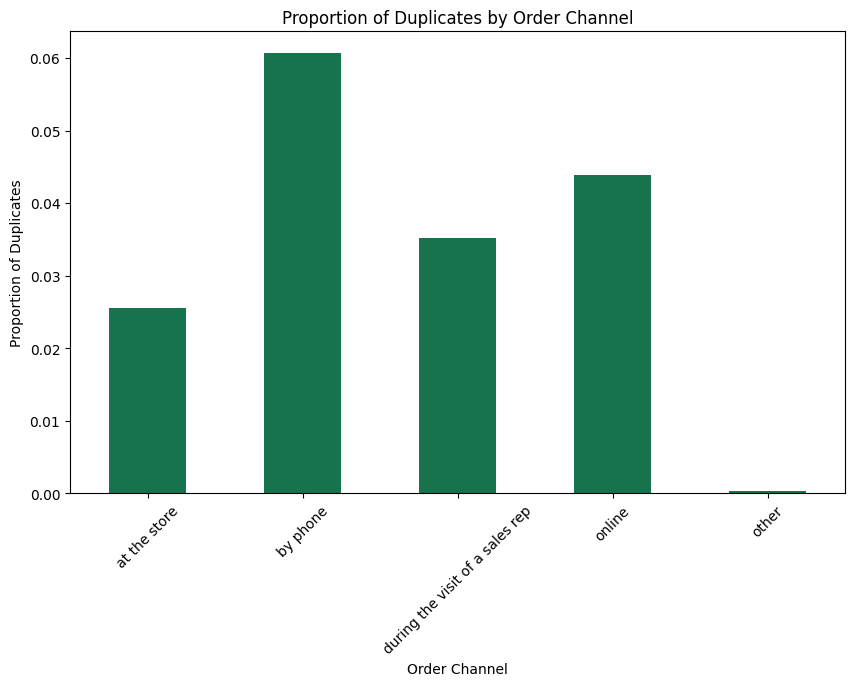

In [16]:

# Identify duplicates based on all columns except for the index
duplicates = t[t.duplicated(subset=None, keep=False)]

# Group by `order_channel` and count the number of duplicates
duplicate_counts_channel = duplicates['order_channel'].value_counts()

# Calculate total sales per channel
total_sales_channel = t.groupby('order_channel')['client_id'].count()

proportion_duplicates = duplicate_counts_channel / total_sales_channel

# Plot the results
plt.figure(figsize=(10, 6))
proportion_duplicates.plot(kind='bar', color='#16734e')
plt.title('Proportion of Duplicates by Order Channel')
plt.xlabel('Order Channel')
plt.ylabel('Proportion of Duplicates')
plt.xticks(rotation=45)
plt.show()

We are getting duplicates in all channels, so it is generalised. However, phone and online have a higher chance of it happening. ClientCo. needs digitalization

In addition, we are going to look at how many duplicates we have, cause the data may need some cleaning

In [17]:
# With these lines of code we are checking for rows that are duplicates on all columns
#  Therefore representing the same transaction.

duplicated_count=t.duplicated().sum()
print(duplicated_count)

1539117


In [18]:
total_rows = len(t)
percentage_duplicated = (duplicated_count / total_rows) * 100

# Print the formatted statement
print(f"Only {percentage_duplicated:.2f}% of the dataset is made of duplicated rows.")


Only 2.43% of the dataset is made of duplicated rows.


Okay, so we have around 2.4% duplicates. Let's remove them

In [19]:
# We remove the duplicated rows from the dataset

t=t.drop_duplicates()

In [20]:
# We ensure everything worked 

print(t.duplicated().any())
print(t.isnull().any())


False
date_order       False
date_invoice     False
product_id       False
client_id        False
sales_net        False
quantity         False
order_channel    False
branch_id        False
invoice_delay    False
dtype: bool


#### 3.3 Further Exploration: Date range and Unique value counts

In [21]:
# We now check validity of date ranges

print(f"Date order range: {t['date_order'].min()} to {t['date_order'].max()}")
print(f"Date invoice range: {t['date_invoice'].min()} to {t['date_invoice'].max()}")

Date order range: 2017-09-22 00:00:00 to 2019-09-22 00:00:00
Date invoice range: 2016-10-12 00:00:00 to 2021-07-13 00:00:00


The range analysis reveals that:

	•	date_order ranges from 2017-09-22 to 2019-09-22.
	•	date_invoice ranges from 2016-10-12 to 2021-07-13.

There is a discrepancy between the order dates and invoice dates:

	1.	Some invoice dates predate order dates: invoices starting from 2016 when orders only start start from 2017.
	2.	some invoice dates postdate order dates: invoices from 2019 to 2021 when orders end in 2019.

Potential Issues and Actions

	1.	This may have occurred because of data entry errors.
	
	2.	Late invoices could occur because invoices can be generated after the order with some delay(can be acceptable). 

For simplicity and because they represent the same information, after some discussion with the company we decided to only keep order dates.

In [22]:
# Count the number of unique branch_id values
unique_branch_ids = t['branch_id'].nunique()

print(f'Number of unique branch_id values: {unique_branch_ids}')

Number of unique branch_id values: 582


In [23]:
# Count the number of unique clients 
unique_clients_ids = t['client_id'].nunique()

print(f'Number of unique client_id values: {unique_clients_ids}')

Number of unique client_id values: 170589


In [24]:
# How many product_id

unique_product_count = t['product_id'].nunique()

print(f'The number of different product_id values is: {unique_product_count}')

The number of different product_id values is: 607418


### **4. Feature Enginering**

#### 4.1 Interaction Features

In [25]:
# Create new feature to capture sales value x unit quantity, providing insight into pricing strategy

t['sales_per_quantity'] = t['sales_net'] / t['quantity']

#### 4.2 Date Based Features

In [26]:
# We extract some date features from order_date

t['order_year']=t['date_order'].dt.year
t['order_month']=t['date_order'].dt.month_name()
t['order_day_month']=t['date_order'].dt.day
t['order_day_week']=t['date_order'].dt.day_name()

#### 4.3 Aggregating Features

In [27]:
# Aggregate monthly sales
monthly_sales = t.groupby(t['date_order'].dt.to_period('M'))['sales_net'].sum().reset_index()
monthly_sales.columns = ['order_period', 'monthly_sales']
t['order_period'] = t['date_order'].dt.to_period('M')
t = t.merge(monthly_sales, on='order_period', how='left')

In [28]:
# Check for duplicates in monthly_sales
assert monthly_sales['order_period'].is_unique, "Duplicate order_periods found in monthly_sales"

#### 4.4 Lag Features

In [29]:
# Create previous month sales
t['previous_month_sales'] = t['monthly_sales'].shift(1)
t['previous_month_sales'] = t['previous_month_sales'].fillna(method='bfill')

C:\Users\Inas\AppData\Local\Temp\ipykernel_23884\914993342.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  t['previous_month_sales'] = t['previous_month_sales'].fillna(method='bfill')


In [30]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61780198 entries, 0 to 61780197
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date_order            datetime64[ns]
 1   date_invoice          datetime64[ns]
 2   product_id            int64         
 3   client_id             int64         
 4   sales_net             float64       
 5   quantity              int64         
 6   order_channel         object        
 7   branch_id             int64         
 8   invoice_delay         float64       
 9   sales_per_quantity    float64       
 10  order_year            int32         
 11  order_month           object        
 12  order_day_month       int32         
 13  order_day_week        object        
 14  order_period          period[M]     
 15  monthly_sales         float64       
 16  previous_month_sales  float64       
dtypes: datetime64[ns](2), float64(5), int32(2), int64(4), object(3), period[M](1)
memo

In [31]:
# We check for null values as we might expect one from the creation of the lag feature

null_count=t.isnull().sum()
print(null_count)

date_order              0
date_invoice            0
product_id              0
client_id               0
sales_net               0
quantity                0
order_channel           0
branch_id               0
invoice_delay           0
sales_per_quantity      0
order_year              0
order_month             0
order_day_month         0
order_day_week          0
order_period            0
monthly_sales           0
previous_month_sales    0
dtype: int64


#### 4.5 Memory Optimization with Numpy and Saving the file to Parquet

In [32]:
# Function to downcast numerical columns
def downcast_t(t):
    # Downcast floats
    float_cols = t.select_dtypes(include=['float64']).columns
    t[float_cols] = t[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Downcast integers
    int_cols = t.select_dtypes(include=['int64']).columns
    t[int_cols] = t[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Ensure datetime columns are in datetime64[ns] format
    datetime_cols = t.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
    t[datetime_cols] = t[datetime_cols].apply(pd.to_datetime)
    
    return t

# Apply downcasting
t = downcast_t(t)

# Display the dataframe info to check the changes
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61780198 entries, 0 to 61780197
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date_order            datetime64[ns]
 1   date_invoice          datetime64[ns]
 2   product_id            int32         
 3   client_id             int32         
 4   sales_net             float64       
 5   quantity              int32         
 6   order_channel         object        
 7   branch_id             int16         
 8   invoice_delay         float32       
 9   sales_per_quantity    float64       
 10  order_year            int32         
 11  order_month           object        
 12  order_day_month       int32         
 13  order_day_week        object        
 14  order_period          period[M]     
 15  monthly_sales         float64       
 16  previous_month_sales  float64       
dtypes: datetime64[ns](2), float32(1), float64(4), int16(1), int32(5), object(3), perio

Memory decreased, let's decrease it further

In [33]:
# We optimize data formats

t.product_id= t.product_id.astype(np.int32)
t.client_id= t.client_id.astype(np.int32)
t.sales_net=t.sales_net.astype(np.float32)
t.quantity= t.quantity.astype(np.int32)
t.order_channel= t.order_channel.astype('category')
t.branch_id= t.branch_id.astype(np.int16)
t.sales_per_quantity=t.sales_per_quantity.astype(np.float32)
t.order_year = t.order_year.astype(np.int16)
t.monthly_sales = t.monthly_sales.astype(np.float32)
t.previous_month_sales = t.previous_month_sales.astype(np.float32)
t.order_month = t.order_month.astype('category')
t.order_day_week = t.order_day_week.astype('category')
t.order_day_month = t.order_day_month.astype(np.int8)

In [34]:
# Checking how much memory we are now using
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61780198 entries, 0 to 61780197
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date_order            datetime64[ns]
 1   date_invoice          datetime64[ns]
 2   product_id            int32         
 3   client_id             int32         
 4   sales_net             float32       
 5   quantity              int32         
 6   order_channel         category      
 7   branch_id             int16         
 8   invoice_delay         float32       
 9   sales_per_quantity    float32       
 10  order_year            int16         
 11  order_month           category      
 12  order_day_month       int8          
 13  order_day_week        category      
 14  order_period          period[M]     
 15  monthly_sales         float32       
 16  previous_month_sales  float32       
dtypes: category(3), datetime64[ns](2), float32(5), int16(2), int32(3), int8(1), period

We almost saved 4GB of memory. We will now write it as **parquet**

In [35]:
t.to_parquet('data/transactions_cleaned')

In [59]:
t=pd.read_parquet('data/transactions_cleaned')
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61780198 entries, 0 to 61780197
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date_order            datetime64[ns]
 1   date_invoice          datetime64[ns]
 2   product_id            int32         
 3   client_id             int32         
 4   sales_net             float32       
 5   quantity              int32         
 6   order_channel         category      
 7   branch_id             int16         
 8   invoice_delay         float32       
 9   sales_per_quantity    float32       
 10  order_year            int16         
 11  order_month           category      
 12  order_day_month       int8          
 13  order_day_week        category      
 14  order_period          period[M]     
 15  monthly_sales         float32       
 16  previous_month_sales  float32       
dtypes: category(3), datetime64[ns](2), float32(5), int16(2), int32(3), int8(1), period

### **5. Exploration Data Analysis (EDA): Trends and Behaviours**

In the Meeting Minutes, some executives mentioned that Online Sales were not on par with other channels. Let's check for exactly that!

#### 5.1 Sales per Channel

C:\Users\Inas\AppData\Local\Temp\ipykernel_23884\1474365023.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_sales = t.groupby([t['date_order'].dt.to_period('M'), 'order_channel'])['sales_net'].sum().unstack().fillna(0)


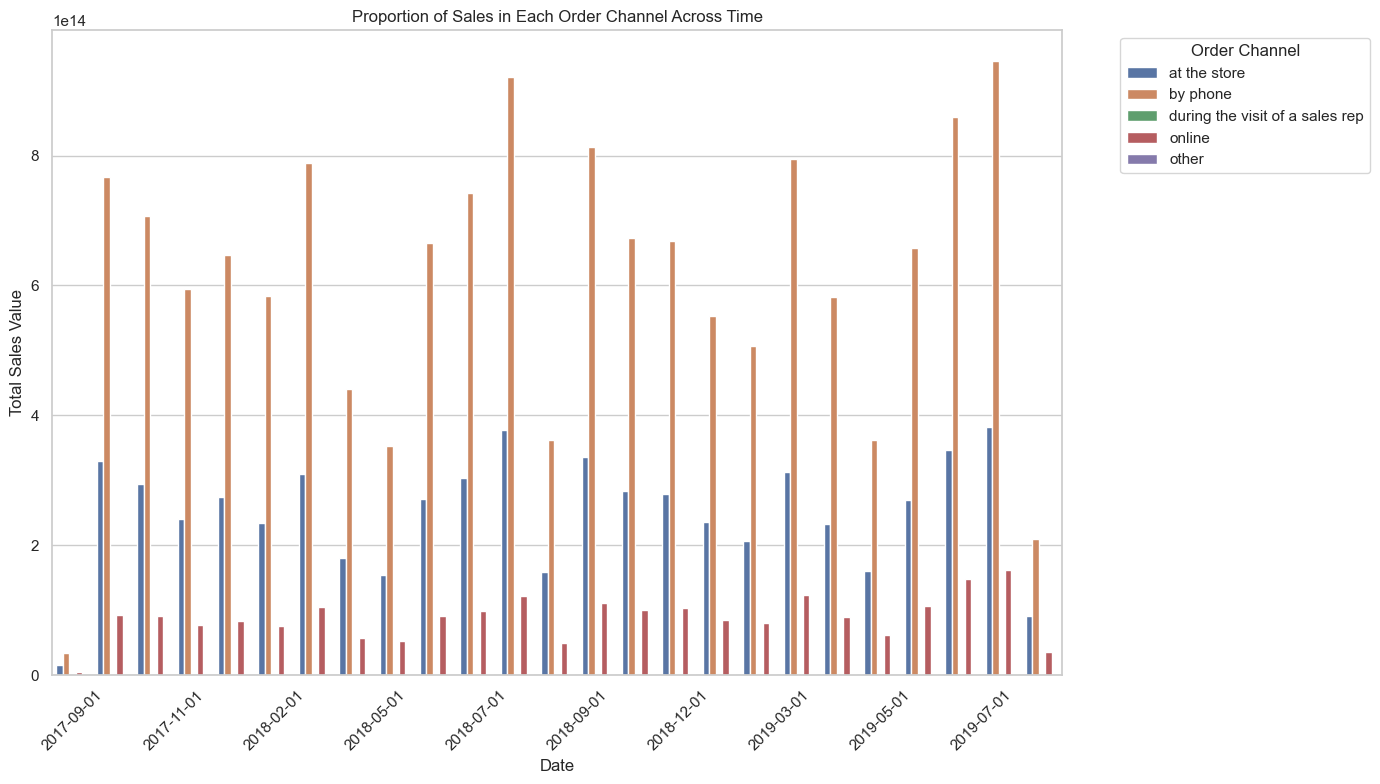

In [39]:
# Group by period and order_channel to sum the sales_net
monthly_sales = t.groupby([t['date_order'].dt.to_period('M'), 'order_channel'])['sales_net'].sum().unstack().fillna(0)

# Normalize to get proportions
monthly_sales_proportion = monthly_sales.divide(monthly_sales.sum(axis=1), axis=0)

# Reset index for plotting
monthly_sales_proportion = monthly_sales_proportion.reset_index()
monthly_sales_proportion['date_order'] = monthly_sales_proportion['date_order'].dt.to_timestamp()

# Melt the DataFrame for seaborn
monthly_sales_melted = monthly_sales_proportion.melt(id_vars='date_order', value_vars=monthly_sales_proportion.columns[1:], var_name='order_channel', value_name='proportion')

# Total sales for each month (using the existing 'monthly_sales' column)
monthly_total_sales = t.groupby(t['date_order'].dt.to_period('M'))['monthly_sales'].sum().reset_index()
monthly_total_sales['date_order'] = monthly_total_sales['date_order'].dt.to_timestamp()

# Merge the proportion data with total sales
monthly_sales_melted = monthly_sales_melted.merge(monthly_total_sales, on='date_order')
monthly_sales_melted['sales_value'] = monthly_sales_melted['proportion'] * monthly_sales_melted['monthly_sales']

# Set the style
sns.set(style="whitegrid")

# Create the stacked barplot
plt.figure(figsize=(14, 8))
sns.barplot(x='date_order', y='sales_value', hue='order_channel', data=monthly_sales_melted, errorbar=None)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('Proportion of Sales in Each Order Channel Across Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Value')
plt.legend(title='Order Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve x-axis ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

# Show the plot
plt.tight_layout()
plt.show()

While we can see changes in the total sales value during these 2 years, it seems like the proportion of sales in each order channel remains relatively constant over time.

#### 5.2 Seasonal Time Lines Decomposition

In the Meeting Minutes, it was also mentioned that some Demand & Stock Forecasting was required. We will try to discover just that.

In [40]:
t['year_and_month']=t['date_order'].dt.strftime('%Y-%m')

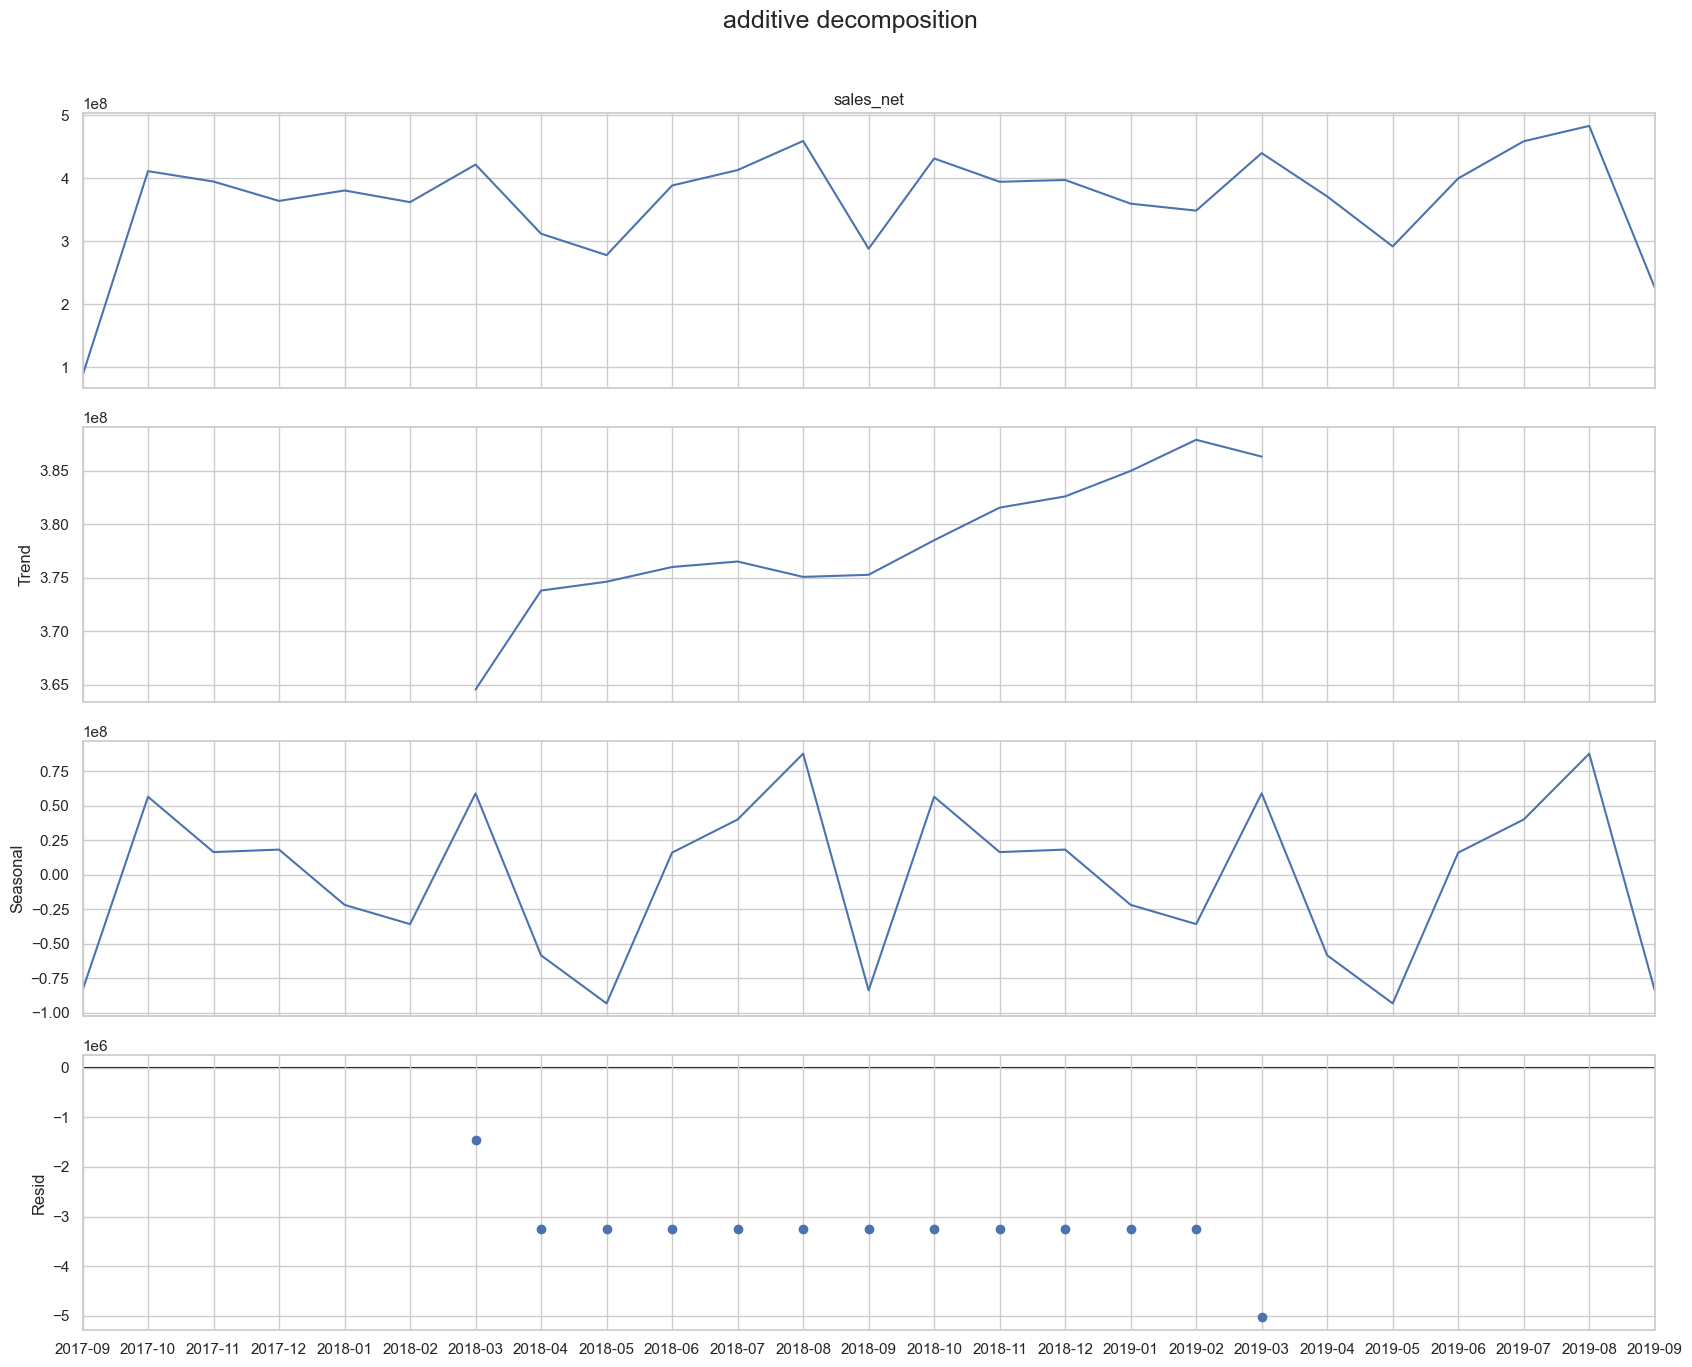

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

def getDecompositionPlot(data,freq,title):
    results = seasonal_decompose(
        x=data, 
        period=freq,
        model="additive"
        )

    plt.rc("figure", figsize=(17,13))
    results.plot().suptitle(title, y=1.05, fontsize = 18)
    plt.show()

getDecompositionPlot(t.groupby('year_and_month')['sales_net'].sum(),12,"additive decomposition")

So it seems there is some seasonality in May and September. This is good because it means some predictability

#### 5.3 Sales per Day of Week

C:\Users\Inas\AppData\Local\Temp\ipykernel_23884\2162692417.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_day = t.groupby('order_day_week')['sales_net'].sum().reindex(


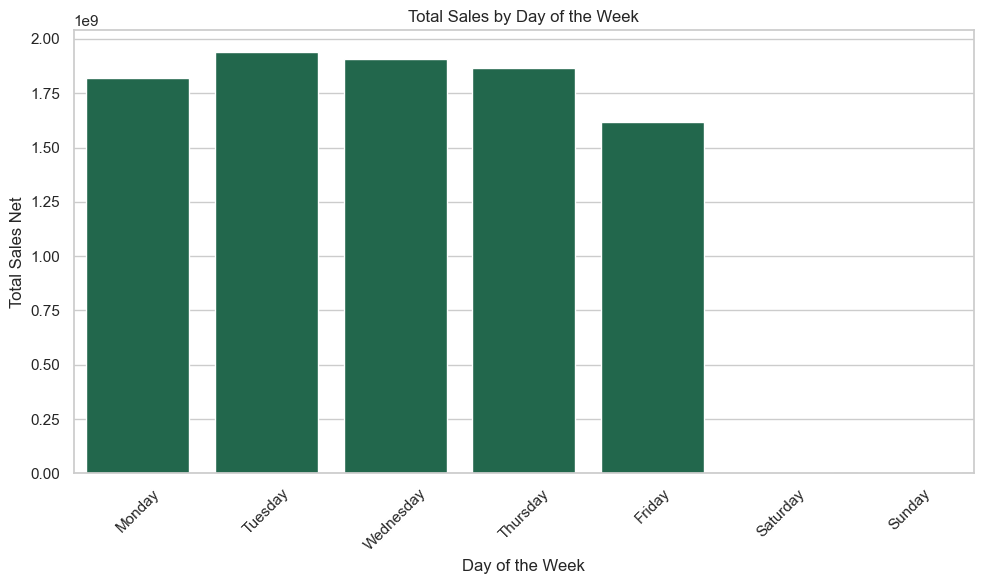

In [42]:
# sales by day of the week
sales_by_day = t.groupby('order_day_week')['sales_net'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot the sales by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values,color='#16734e')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales Net')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
t['date_order'] = pd.to_datetime(t['date_order'])
t.reset_index(drop=True, inplace=True)

#### 5.4 Day of Week Metrics - Interactive Plot 

In [44]:

from pandas.api.types import CategoricalDtype

# Group by 'date_order' and 'order_day_week' and sum 'sales_net'
week_sales = t.groupby(['date_order', 'order_day_week'])['sales_net'].sum().reset_index()

# Filter out zero sales
week_sales = week_sales[week_sales['sales_net'] > 0]

# Set the categorical order for the days of the week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
week_sales['order_day_week'] = week_sales['order_day_week'].astype(cat_type)
week_sales = week_sales.sort_values('order_day_week')

# Create the box plot
fig = px.box(week_sales, x="order_day_week", y="sales_net",
             color="order_day_week",
             title="Sales by Day of Week",
             labels={"sales_net": "Revenue", "order_day_week": "Day of Week"})

# Customize the plot
fig.update_layout(
    xaxis_title="Day of the Week",
    yaxis_title="Sales Net",
    yaxis_tickformat=",.0f",
    legend_title_text='Day of the Week'
)

fig.show()

C:\Users\Inas\AppData\Local\Temp\ipykernel_23884\2600087080.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  week_sales = t.groupby(['date_order', 'order_day_week'])['sales_net'].sum().reset_index()


#### 5.5 Curve of Client Sales Distribution

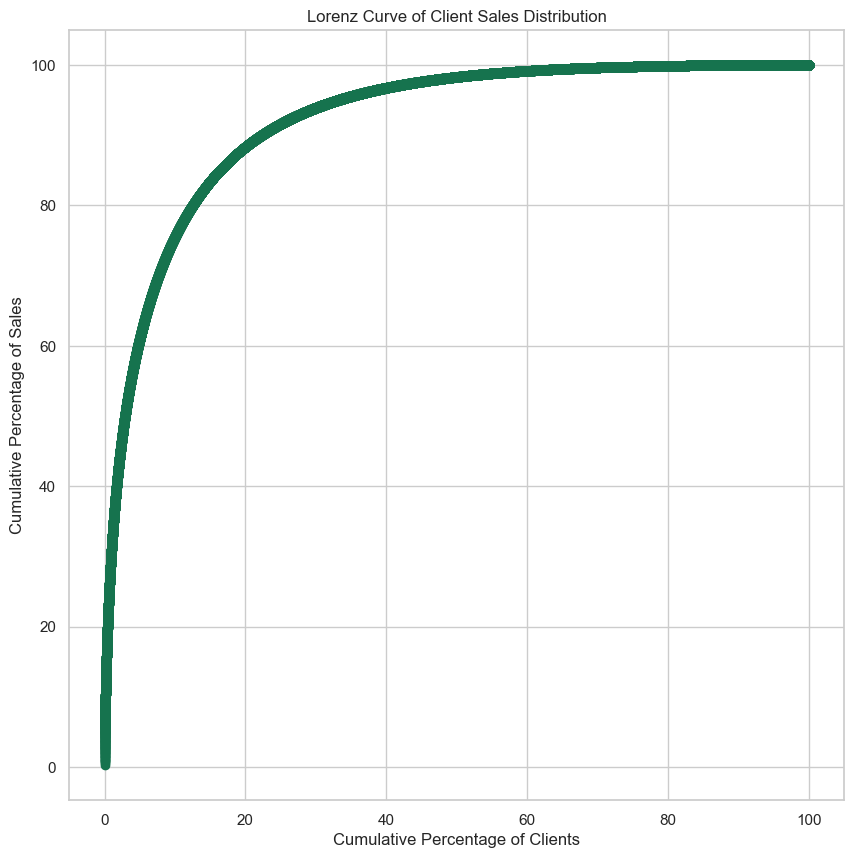

In [45]:
client_sales = t.groupby('client_id')['sales_net'].sum().reset_index()

# Calculate the cumulative percentage of clients and sales
client_sales_sorted = client_sales.sort_values(by='sales_net', ascending=False)
client_sales_sorted['cumulative_client_percentage'] = np.arange(1, len(client_sales_sorted) + 1) / len(client_sales_sorted) * 100
client_sales_sorted['cumulative_sales_percentage'] = client_sales_sorted['sales_net'].cumsum() / client_sales_sorted['sales_net'].sum() * 100

# Plot the cumulative percentage of clients vs. cumulative percentage of sales
plt.figure(figsize=(10, 10))
plt.plot(client_sales_sorted['cumulative_client_percentage'], client_sales_sorted['cumulative_sales_percentage'], marker='o', linestyle='-', color='#16734e')
plt.xlabel('Cumulative Percentage of Clients')
plt.ylabel('Cumulative Percentage of Sales')
plt.title('Lorenz Curve of Client Sales Distribution')
plt.show()

#### 5.6 Monthly Refunds over time

In [46]:


# Filter out refunds (negative sales_net) and calculate the absolute value for refunds
refunds = t[t['sales_net'] < 0].copy()
refunds['refunds_net'] = refunds['sales_net'].abs()

# Group by 'year_month' and sum 'refunds_net'
monthly_refunds = refunds.groupby('year_and_month')['refunds_net'].sum().reset_index()

# Convert 'year_month' to string for Plotly
monthly_refunds['year_and_month'] = monthly_refunds['year_and_month'].astype(str)

# Create the line plot
fig = px.line(monthly_refunds, x='year_and_month', y='refunds_net',
              title='Monthly Refunds Value Over Time',
              labels={'year_month': 'Month', 'refunds_net': 'Refunds Value'})

# Customize the plot
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Refunds Value",
    yaxis_tickformat=",.0f",
    xaxis_tickangle=45
)

fig.show()

#### 5.7 Sales and Refunds over time

In [47]:
import pandas as pd
import plotly.express as px

# Ensure date_order is in datetime format
t['date_order'] = pd.to_datetime(t['date_order'])

# Create 'year_and_month' column
t['year_and_month'] = t['date_order'].dt.to_period('M')

# Filter out refunds (negative sales_net) and calculate the absolute value for refunds
refunds = t[t['sales_net'] < 0].copy()
refunds['refunds_net'] = refunds['sales_net'].abs()

# Group by 'year_and_month' and sum 'refunds_net'
monthly_refunds = refunds.groupby('year_and_month')['refunds_net'].sum().reset_index()

# Group by 'year_and_month' and sum 'sales_net' for sales
monthly_sales = t.groupby('year_and_month')['sales_net'].sum().reset_index()

# Merge sales and refunds
monthly_data = pd.merge(monthly_sales, monthly_refunds, on='year_and_month', how='left').fillna(0)

# Convert 'year_and_month' to string for Plotly
monthly_data['year_and_month'] = monthly_data['year_and_month'].astype(str)

# Create the line plot for sales
fig = px.line(monthly_data, x='year_and_month', y='sales_net', 
              title='Monthly Sales and Refunds Value Over Time',
              labels={'year_and_month': 'Month', 'sales_net': 'Sales Value'})

# Add the line plot for refunds
fig.add_scatter(x=monthly_data['year_and_month'], y=monthly_data['refunds_net'], mode='lines', name='Refunds Value')

# Customize the plot
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Value",
    yaxis_tickformat=",.0f",
    xaxis_tickangle=45
)

fig.show()

#### 5.8 Transactions Over time,  CLTV Curve

In [48]:
# Assuming t is your DataFrame
clients = t[['client_id', 'year_and_month', 'sales_net']]
clients = clients.pivot_table(index='client_id', columns='year_and_month', aggfunc='sum', fill_value=0)

# Calculate the number of months with at least one transaction for each client
clients['transaction_months'] = (clients != 0).sum(axis=1)

# Ensure that 'transaction_months' is a one-dimensional series
transaction_months = clients['transaction_months']

# Plot the histogram
fig = px.histogram(transaction_months,
                   labels={'value': 'Count of months with at least 1 transaction'},
                   title='N° of Customers')
fig.update_layout(bargap=0.1)
fig.show()


#### 5.9 Curve of Product Sales Distribution

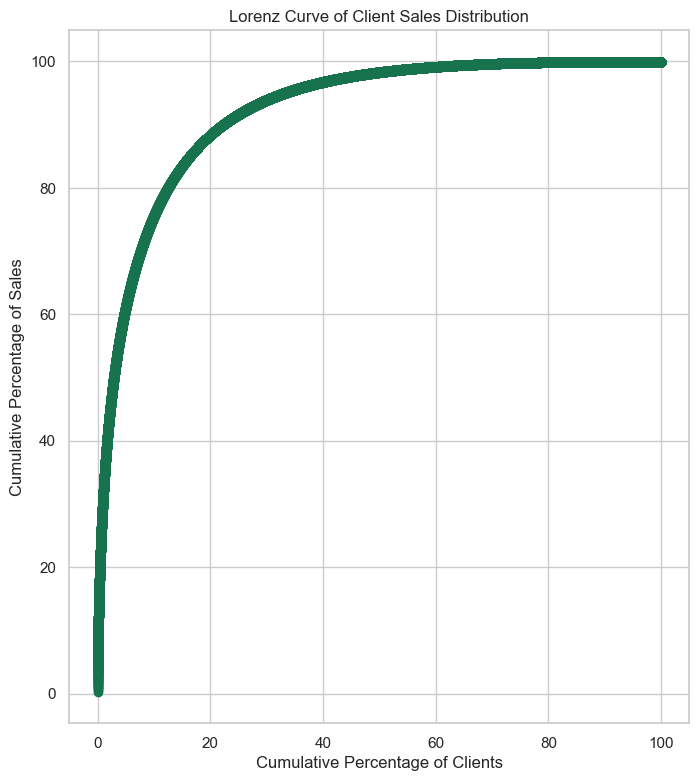

In [49]:
client_sales = t.groupby('client_id')['sales_net'].sum().reset_index()

# Calculate the cumulative percentage of clients and sales
client_sales_sorted = client_sales.sort_values(by='sales_net', ascending=False)
client_sales_sorted['cumulative_client_percentage'] = np.arange(1, len(client_sales_sorted) + 1) / len(client_sales_sorted) * 100
client_sales_sorted['cumulative_sales_percentage'] = client_sales_sorted['sales_net'].cumsum() / client_sales_sorted['sales_net'].sum() * 100

# Plot the cumulative percentage of clients vs. cumulative percentage of sales
plt.figure(figsize=(8, 9))
plt.plot(client_sales_sorted['cumulative_client_percentage'], client_sales_sorted['cumulative_sales_percentage'], marker='o', linestyle='-', color='#16734e')
plt.xlabel('Cumulative Percentage of Clients')
plt.ylabel('Cumulative Percentage of Sales')
plt.title('Lorenz Curve of Client Sales Distribution')
plt.show()

#### 5.10 Top 20 Branches By Number of Sales

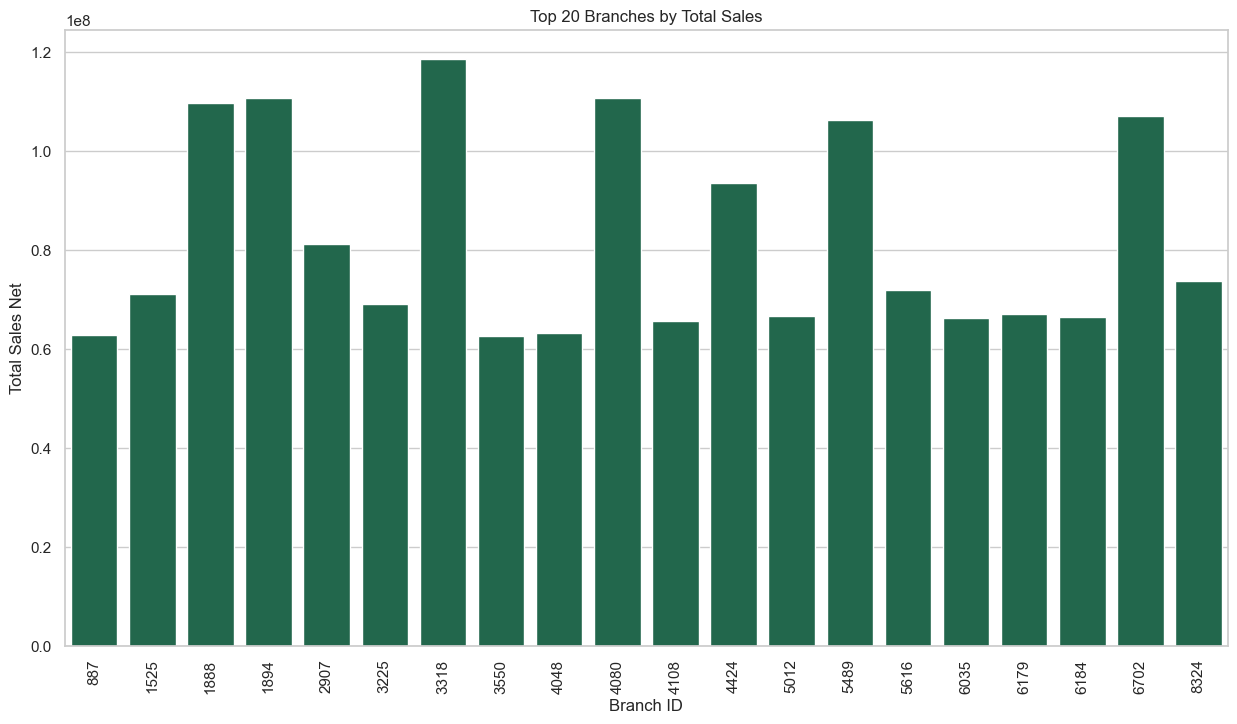

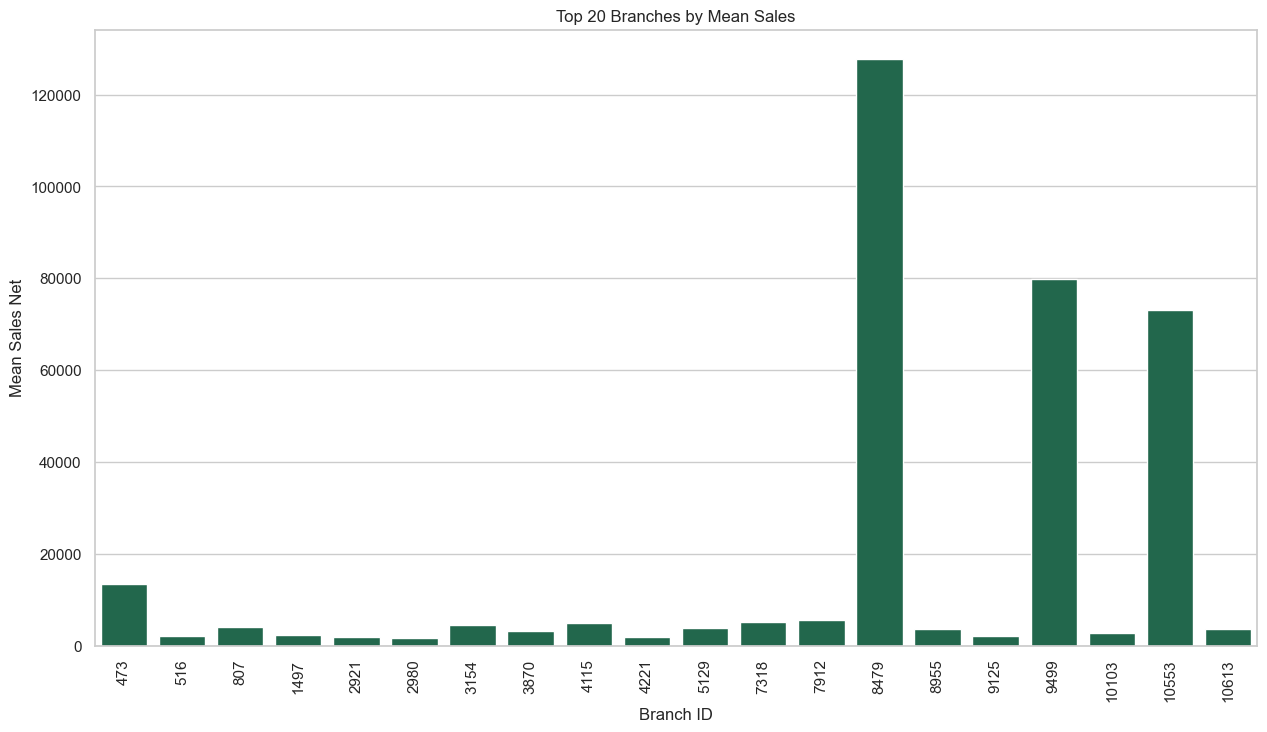

In [50]:
# Plot the top 20 branches by total sales
top_n = 20
top_total_sales = t.groupby('branch_id')['sales_net'].sum().sort_values(ascending=False).head(top_n)

plt.figure(figsize=(15, 8))
sns.barplot(x=top_total_sales.index, y=top_total_sales.values, color='#16734e')
plt.title(f'Top {top_n} Branches by Total Sales')
plt.xlabel('Branch ID')
plt.ylabel('Total Sales Net')
plt.xticks(rotation=90)
plt.show()

# Plot the top 20 branches by mean sales
top_mean_sales = t.groupby('branch_id')['sales_net'].mean().sort_values(ascending=False).head(top_n)

plt.figure(figsize=(15, 8))
sns.barplot(x=top_mean_sales.index, y=top_mean_sales.values, color='#16734e')
plt.title(f'Top {top_n} Branches by Mean Sales')
plt.xlabel('Branch ID')
plt.ylabel('Mean Sales Net')
plt.xticks(rotation=90)
plt.show()

#### 5.11 Retention Curve

In [51]:
from operator import attrgetter
t['first_purchase_date'] = t.groupby('client_id')['date_order'].transform('min')
t['cohort_month'] = t['first_purchase_date'].dt.to_period('M')
t['order_month'] = t['date_order'].dt.to_period('M')

# get the number of months between the order and the cohort month
t['cohort_index'] = (t['order_month'] - t['cohort_month']).apply(attrgetter('n'))

In [53]:
# Pivot table to count unique clients per cohort
cohort_data = t.pivot_table(index='cohort_month',
                             columns='cohort_index',
                             values='client_id',
                             aggfunc=pd.Series.nunique)

# Divide each column by the number of clients in the cohort to get the retention rate
cohort_size = cohort_data.iloc[:, 0]
retention = cohort_data.divide(cohort_size, axis=0)


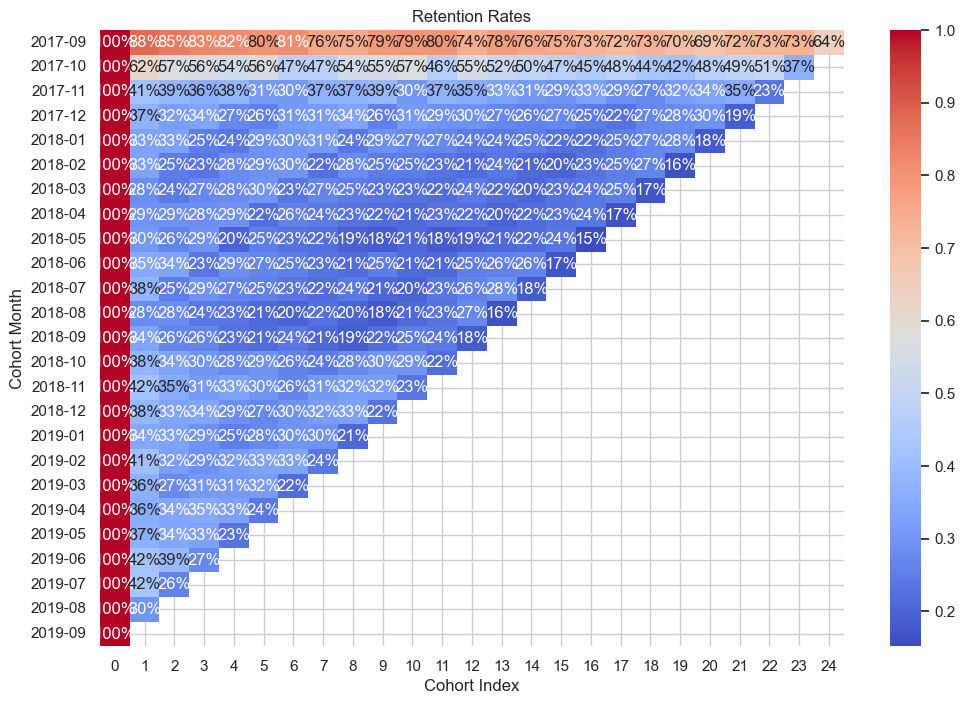

In [54]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='coolwarm')
plt.title('Retention Rates')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.show()

In [65]:
# Pivot table to count unique clients per cohort
cohort_data = t.pivot_table(index='cohort_month',
                            columns='cohort_index',
                            values='client_id',
                            aggfunc=pd.Series.nunique)

# Calculate the cohort size
cohort_size = cohort_data.iloc[:, 0]

# Calculate the retention rate
retention = cohort_data.divide(cohort_size, axis=0)

# Transpose the data for plotting
cohorts_t = retention.transpose()

# Calculate the weighted mean retention rate for each cohort index
weighted_retention = cohorts_t.multiply(cohort_size, axis=1).sum(axis=1) / cohort_size.sum()

# Create a DataFrame to store the weighted mean retention rates
weighted_mean_retention_df = pd.DataFrame(weighted_retention, columns=['weighted_mean_retention'])

# Identify cohorts with at least 12 months of data
long_cohorts = cohorts_t.columns[cohorts_t.count() >= 12]

# Plot with Plotly
fig = px.line(cohorts_t, title="Cohort Retention Rates & Overall Weighted Retention Rate", height=600) 

# Add the weighted average line
fig.add_scatter(x=weighted_mean_retention_df.index, y=weighted_mean_retention_df['weighted_mean_retention'], mode='lines', name='Weighted Average Retention', line=dict(color='red', width=4))

# Update the layout
fig.update_layout(yaxis=dict(title='% of Active'), xaxis=dict(title='Cohort Index'))

# Update traces to highlight cohorts with 12 months or more
for trace in fig.data:
    if trace.name != 'Weighted Average Retention' and trace.name not in long_cohorts:
        trace.update(line=dict(color='grey', width=2), showlegend=False)

fig.show()

Here, we transpose the cohorts but we are also going to take into account the number of customers in each cohort, so that the overall mean retention rate is not biased by the amount of cohorts

### **6. Creating a Final Client Analysis table**

#### 6.1 Creating additional features within the table

In [ ]:
# Ensure date_order is in datetime format
t['date_order'] = pd.to_datetime(t['date_order'])

# Sort by client_id and date_order
t = t.sort_values(by=['client_id', 'date_order'])

# Remove duplicate tickets on the same day for each client
t['order_date'] = t['date_order'].dt.date
t_unique_days = t.drop_duplicates(subset=['client_id', 'order_date'])

# Calculate days between orders
t_unique_days['days_between_orders'] = t_unique_days.groupby('client_id')['date_order'].diff().dt.days

# Replace NaN values in days_between_orders with a zero
t_unique_days['days_between_orders'] = t_unique_days['days_between_orders'].fillna(0)

# Group by client_id and calculate metrics
grouped = t_unique_days.groupby('client_id')
df = grouped.agg(
    first_order_date=('date_order', 'min'),
    last_order_date=('date_order', 'max'),
    total_sales=('sales_net', 'sum'),
    total_quantity=('quantity', 'sum'),
    num_tickets=('sales_net', 'count'),
    num_negative_tickets=('sales_net', lambda x: (x < 0).sum()),
    sum_negative_sales=('sales_net', lambda x: x[x < 0].sum()),
    sum_positive_sales=('sales_net', lambda x: x[x > 0].sum()),
    unique_branches=('branch_id', 'nunique'),
    max_days_between_orders=('days_between_orders', 'max')
).reset_index()

# Calculate additional metrics
df['total_period'] = (df['last_order_date'] - df['first_order_date']).dt.days
df['recency'] = (pd.to_datetime('2019-09-22') - df['last_order_date']).dt.days

# Calculate the average days between orders and standard deviation
def avg_std_days_between_orders(x):
    if len(x) > 1:
        diffs = x.diff().dt.days.dropna()
        return pd.Series([diffs.mean(), diffs.std()])
    else:
        return pd.Series([0, 0])

days_between_orders = t_unique_days.groupby('client_id')['date_order'].apply(lambda x: avg_std_days_between_orders(x)).unstack().reset_index()
days_between_orders.columns = ['client_id', 'avg_days_between_orders', 'std_days_between_orders']

# Merge days_between_orders with df
df = df.merge(days_between_orders, on='client_id', how='left')

# Ensure no division by zero in total_period
df['total_period'] = df['total_period'].replace(0, np.nan)
df['total_period'] = df['total_period'].fillna(0)

# Replace NaN values in std_days_between_orders
df['std_days_between_orders'] = df['std_days_between_orders'].fillna(0)

# Calculate the purchase frequency per customer
df['monthly_frequency'] = np.where(df['num_tickets'] > 1, df['num_tickets'] / (df['total_period'] / 30), 0)

# Replace NaN or infinite values in monthly_frequency
df['monthly_frequency'] = df['monthly_frequency'].replace([np.inf, -np.inf], 0).fillna(0)

# Calculate the average order value (AOV) per customer
df['avg_sale_value'] = df['total_sales'] / df['num_tickets']

# Handle NaN or zero values in avg_sale_value
df['avg_sale_value'] = df['avg_sale_value'].replace([np.inf, -np.inf], 0).fillna(0)

# Assume the average customer lifespan (in months or years)
# For example, let's assume an average lifespan of 24 months (2 years)
average_customer_lifespan_months = 24
average_customer_lifespan_years = average_customer_lifespan_months / 12

# Calculate the monthly CLV
df['avg_monthly_sales'] = df['avg_sale_value'] * df['monthly_frequency'] * average_customer_lifespan_months

# Calculate the yearly CLV
df['avg_yearly_sales'] = df['avg_sale_value'] * df['monthly_frequency'] * average_customer_lifespan_years * 12

# Handle NaN or infinite values in CLV
df['avg_monthly_sales'] = df['avg_monthly_sales'].replace([np.inf, -np.inf], 0).fillna(0)
df['avg_yearly_sales'] = df['avg_yearly_sales'].replace([np.inf, -np.inf], 0).fillna(0)

# Display the updated DataFrame
df[['client_id', 'first_order_date', 'last_order_date', 'total_sales', 'total_quantity', 'num_tickets',
         'num_negative_tickets', 'sum_negative_sales', 'sum_positive_sales', 'unique_branches', 
         'max_days_between_orders', 'total_period', 'recency', 'avg_days_between_orders', 'std_days_between_orders', 
         'monthly_frequency', 'avg_sale_value', 'avg_monthly_sales', 'avg_yearly_sales']].head()

# Check the number of unique clients
unique_clients_t = t['client_id'].nunique()
unique_clients_df = df['client_id'].nunique()

print(f"Unique clients in transaction dataset: {unique_clients_t}")
print(f"Unique clients in aggregated dataset: {unique_clients_df}")

Unique clients in transaction dataset: 170589
Unique clients in aggregated dataset: 170589


In [ ]:

# Sort by client_id and date_order
t = t.sort_values(by=['client_id', 'date_order'])

# Calculate days between orders
t['days_between_orders'] = t.groupby('client_id')['date_order'].diff().dt.days

# Replace NaN values in days_between_orders with zero
t['days_between_orders'] = t['days_between_orders'].fillna(0)

# Calculate the median days between orders for each client
median_days_between_orders = t.groupby('client_id')['days_between_orders'].median().reset_index()
median_days_between_orders.columns = ['client_id', 'median_days_between_orders']

# Merge with the existing df dataframe
df = df.merge(median_days_between_orders, on='client_id', how='left')

# Display the updated dataframe
df[['client_id', 'median_days_between_orders']].head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   client_id                   170589 non-null  int32         
 1   first_order_date            170589 non-null  datetime64[ns]
 2   last_order_date             170589 non-null  datetime64[ns]
 3   total_sales                 170589 non-null  float32       
 4   total_quantity              170589 non-null  int32         
 5   num_tickets                 170589 non-null  int64         
 6   num_negative_tickets        170589 non-null  int64         
 7   sum_negative_sales          170589 non-null  float32       
 8   sum_positive_sales          170589 non-null  float32       
 9   unique_branches             170589 non-null  int64         
 10  max_days_between_orders     170589 non-null  float64       
 11  total_period                170589 non-

In [ ]:
df['sum_negative_sales'] = df['sum_negative_sales'].fillna(0)
df['sum_positive_sales'] = df['sum_positive_sales'].fillna(0)

df['percentage_negative_sales'] = np.where(df['sum_positive_sales'] != 0,
                                           df['sum_negative_sales'] / df['sum_positive_sales'],
                                           0)


df=df.drop(columns=['sum_negative_sales','sum_positive_sales'])

#### 6.2 Checking for infinite values

In [ ]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Check for infinite values in numeric columns
is_infinite = numeric_cols.applymap(np.isinf)

# Check if any value is infinite in the numeric columns
has_infinite_values = is_infinite.values.any()
print(f"Dataset contains infinite values: {has_infinite_values}")

# Identifying Columns with Infinite Values
columns_with_infinite = numeric_cols.columns[is_infinite.any()].tolist()
print("Columns with infinite values:", columns_with_infinite)

# Getting Rows and Columns with Infinite Values
# Find the indices of the rows with infinite values
rows_with_infinite = numeric_cols.index[is_infinite.any(axis=1)].tolist()
print("Rows with infinite values:", rows_with_infinite)

C:\Users\Inas\AppData\Local\Temp\ipykernel_2364\1584747310.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Dataset contains infinite values: False
Columns with infinite values: []
Rows with infinite values: []


#### 6.3 Memory Optimization with Numpy and Saving the file to Parquet

In [ ]:
# Function to downcast numerical columns
def downcast_df(df):
    # Downcast floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Downcast integers
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Ensure datetime columns are in datetime64[ns] format
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
    df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)
    return df

# Apply downcasting
df = downcast_df(df)

# Display the dataframe info to check the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   client_id                   170589 non-null  int32         
 1   first_order_date            170589 non-null  datetime64[ns]
 2   last_order_date             170589 non-null  datetime64[ns]
 3   total_sales                 170589 non-null  float32       
 4   total_quantity              170589 non-null  int32         
 5   num_tickets                 170589 non-null  int16         
 6   num_negative_tickets        170589 non-null  int8          
 7   unique_branches             170589 non-null  int16         
 8   max_days_between_orders     170589 non-null  float32       
 9   total_period                170589 non-null  float32       
 10  recency                     170589 non-null  int16         
 11  avg_days_between_orders     170589 non-

In [ ]:
df.to_parquet('data/clients_cleaned')

### **7. Quantiles and Client Distributions**

#### 7.1 Initial Distribution

c:\Users\Inas\anaconda3\envs\capstone\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170589.



Shapiro-Wilk Test: Statistic=0.6004334857482013, p-value=3.94382474096404e-167


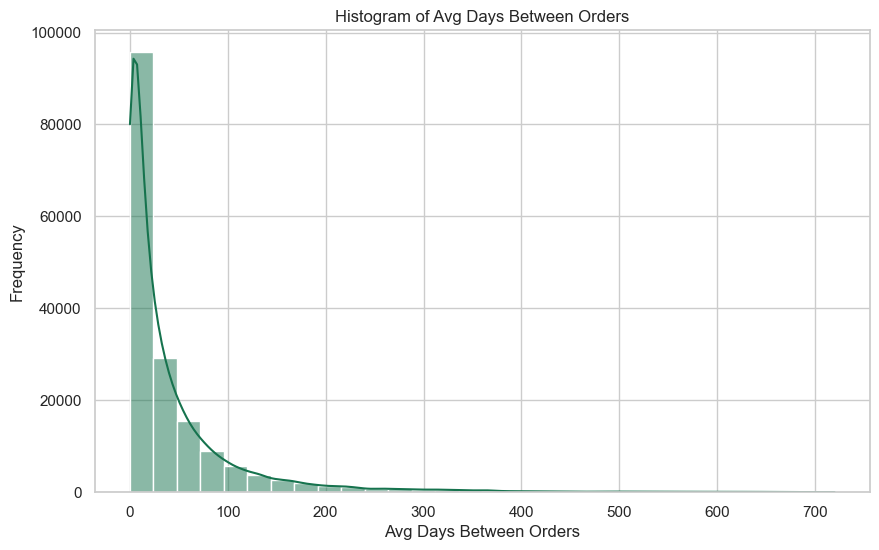

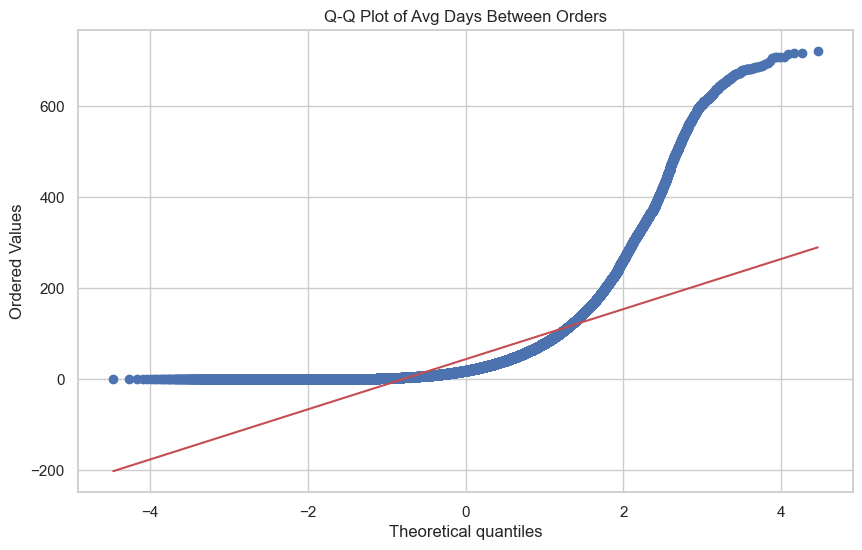

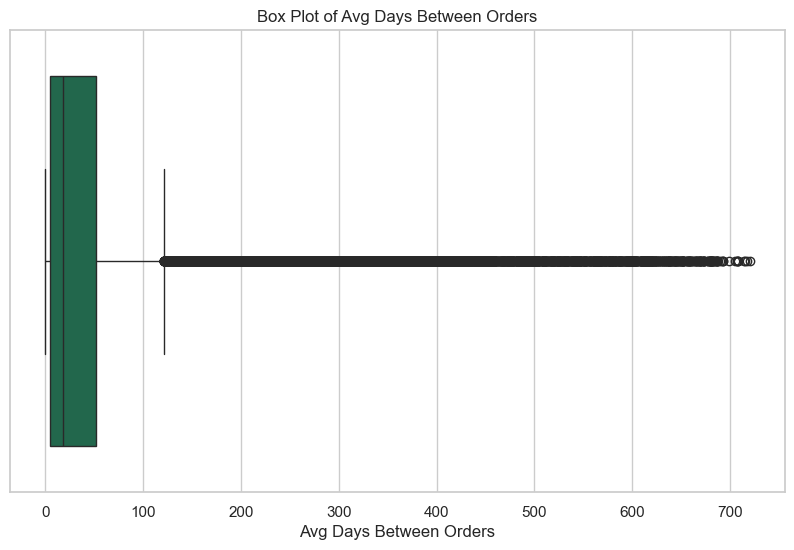

In [ ]:
from scipy.stats import shapiro, probplot

# Drop NaN values from avg_days_between_orders
avg_days_between_orders = df['avg_days_between_orders'].dropna()

# Statistical Test: Shapiro-Wilk Test
stat, p_value = shapiro(avg_days_between_orders)
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}') # not normal!

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(avg_days_between_orders, kde=True, bins=30, color='#16734e')
plt.title('Histogram of Avg Days Between Orders')
plt.xlabel('Avg Days Between Orders')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
probplot(avg_days_between_orders, dist="norm", plot=plt)  
plt.title('Q-Q Plot of Avg Days Between Orders')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=avg_days_between_orders, color='#16734e')
plt.title('Box Plot of Avg Days Between Orders')
plt.xlabel('Avg Days Between Orders')
plt.show()

#### 7.2 Applying a log transformation for normality

In [ ]:
df['log_avg_days_between_orders'] = np.log1p(df['avg_days_between_orders'])


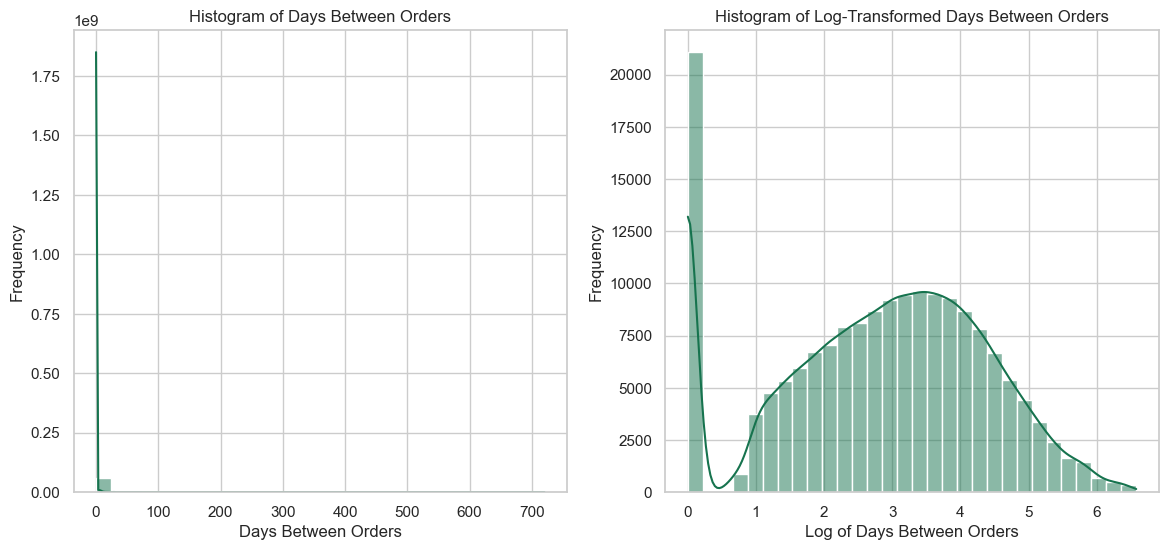

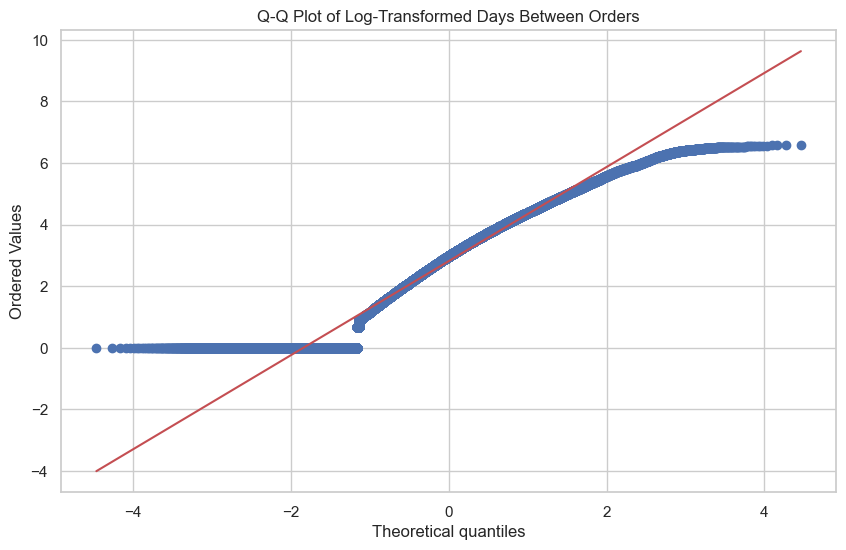

In [ ]:
# Visualize the original and transformed distributions
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.histplot(t['days_between_orders'], kde=True, bins=30,  color='#16734e')
plt.title('Histogram of Days Between Orders')
plt.xlabel('Days Between Orders')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['log_avg_days_between_orders'], kde=True, bins=30, color='#16734e')
plt.title('Histogram of Log-Transformed Days Between Orders')
plt.xlabel('Log of Days Between Orders')
plt.ylabel('Frequency')

plt.show()

# Q-Q plot for the transformed data
plt.figure(figsize=(10, 6))
probplot(df['log_avg_days_between_orders'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Days Between Orders')
plt.show()


#### 7.3 Quantiles Analysis

In [ ]:

# Define the date threshold
date_threshold = pd.to_datetime('2018-09-22')

# Filter the DataFrame to find clients who made their first order after the date threshold
clients_after_threshold = df[df['first_order_date'] > date_threshold]

# Get the number of such clients
num_clients_after_threshold = clients_after_threshold['client_id'].nunique()

print(f"Number of clients who made their first order after {date_threshold.date()}: {num_clients_after_threshold}")

Number of clients who made their first order after 2018-09-22: 28069


In [ ]:
# Calculate the days between orders for each client
t = t.sort_values(by=['client_id', 'date_order'])
t['days_between_orders'] = t.groupby('client_id')['date_order'].diff().dt.days

# Drop NaN values that arise from the diff() method for the first order of each client
t = t.dropna(subset=['days_between_orders'])

In [ ]:


# Calculate the 95th percentile of days between orders
percentile_95_days_between_orders = np.percentile(t['days_between_orders'].dropna(), 95)

print(f"95th percentile of days between orders: {percentile_95_days_between_orders}")



95th percentile of days between orders: 4.0


In [ ]:


# Calculate the maximum days between orders for each client
max_days_between_orders = t.groupby('client_id')['days_between_orders'].max().reset_index()

# Calculate the 98th percentile of these maximum days between orders
percentile_98_max_days_between_orders = np.percentile(max_days_between_orders['days_between_orders'], 98)

print(f"98th percentile of maximum days between orders: {percentile_98_max_days_between_orders}")



98th percentile of maximum days between orders: 439.0


In [ ]:
percentile_99=np.percentile(max_days_between_orders['days_between_orders'],99)



print(f"99th percentile of days between orders: {percentile_99} days")



99th percentile of days between orders: 511.0 days


In [ ]:


# Filter the dataset to include only the records where days_between_orders > 150
clients_with_long_gaps = t[t['days_between_orders'] > 150]

# Identify unique clients
unique_clients_with_long_gaps = clients_with_long_gaps['client_id'].unique()

# Count the number of unique clients
num_clients_with_long_gaps = len(unique_clients_with_long_gaps)

print(f"Number of clients with days between orders larger than 150 days: {num_clients_with_long_gaps}")

Number of clients with days between orders larger than 150 days: 47798


In [ ]:
# Filter the dataset to include only the records where days_between_orders > 150
clients_with_long_gaps = t[t['days_between_orders'] > 180]

# Identify unique clients
unique_clients_with_long_gaps = clients_with_long_gaps['client_id'].unique()

# Count the number of unique clients
num_clients_with_long_gaps = len(unique_clients_with_long_gaps)

print(f"Number of clients with days between orders larger than 180 days: {num_clients_with_long_gaps}")

Number of clients with days between orders larger than 180 days: 37312


In [ ]:
# Filter the dataset to include only the records where days_between_orders > 150
clients_with_long_gaps = t[t['days_between_orders'] > 600]

# Identify unique clients
unique_clients_with_long_gaps = clients_with_long_gaps['client_id'].unique()

# Count the number of unique clients
num_clients_with_long_gaps = len(unique_clients_with_long_gaps)

print(f"Number of clients with days between orders larger than 600 days: {num_clients_with_long_gaps}")

Number of clients with days between orders larger than 600 days: 529


In [ ]:
tickets_per_day = t.groupby(['client_id', 'date_order']).size().reset_index(name='num_tickets_per_day')

# Filter out the groups where the count is greater than 1
multiple_tickets_per_day = tickets_per_day[tickets_per_day['num_tickets_per_day'] > 1]

# Count the number of unique clients who have more than one ticket on the same day
num_clients_multiple_tickets_per_day = multiple_tickets_per_day['client_id'].nunique()

print(f"Number of clients who have had more than one ticket on the same day: {num_clients_multiple_tickets_per_day}")

Number of clients who have had more than one ticket on the same day: 155022
